In [1]:
import psycopg2
from dotenv import load_dotenv
import os

connecting the superbase, postgresSQL database from the environmental variables 

In [2]:
def connect_to_supabase():
    try:
        # Load environment variables from .env
        load_dotenv()

        # Fetch variables
        USER = os.getenv("user")
        PASSWORD = os.getenv("password")
        HOST = os.getenv("host")
        PORT = os.getenv("port")
        DBNAME = os.getenv("dbname")

        connection = psycopg2.connect(
            user=USER,
            password=PASSWORD,
            host=HOST,
            port=PORT,
            dbname=DBNAME,
            # Add these parameters to force password authentication
            sslmode='require',  # Supabase requires SSL
            gssencmode='disable',  # Disable GSSAPI
        )
        print("Connection successful!")

        cursor = connection.cursor()
        cursor.execute("SELECT NOW();")
        result = cursor.fetchone()
        print("Current Time:", result)
        return connection, cursor
    except Exception as e:
        print(f"Failed to connect: {e}")
        return None, None

def close_connection(connection, cursor):
    # Close the cursor and connection
    if cursor:
        cursor.close()
        print("Cursor closed.")
    if connection:
        connection.close()
        print("Connection closed.")

        
connection, cursor = connect_to_supabase()

if cursor is not None:
    query = """SELECT w.recorded_at, w.unit, w.water_level, alert_level, minor_flood_level, major_flood_level 
            FROM water_level_measurement as w 
            INNER JOIN gauging_station as g 
            ON w.station_id = g.station_id 
            WHERE g.station_id = 1"""
            
    cursor.execute(query)
    rows = cursor.fetchall()
    count = 0
    for row in rows:
        count += 1
        print(row)
    print("Total rows:", count)
else:
    print("Database connection failed. Cannot execute query.")


Connection successful!
Current Time: (datetime.datetime(2025, 5, 19, 12, 44, 8, 334463, tzinfo=datetime.timezone.utc),)
Current Time: (datetime.datetime(2025, 5, 19, 12, 44, 8, 334463, tzinfo=datetime.timezone.utc),)
(datetime.datetime(2021, 3, 27, 8, 0), 'ft', 1.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 3, 27, 9, 0), 'ft', 1.2, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 23, 8, 0), 'ft', 1.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 23, 9, 0), 'ft', 1.7, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 30, 8, 0), 'ft', 1.0, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 4, 30, 9, 0), 'ft', 0.8, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 2, 8, 0), 'ft', 1.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 2, 9, 0), 'ft', 1.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 4, 8, 0), 'ft', 2.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 4, 9, 0), 'ft', 2.3, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 5, 8, 0), 'ft', 2.1, 4.0, 5.0, 7.0)
(datetime.datetime(2021, 5, 5, 9, 0), 'ft', 2.25, 4.0, 5.0, 7.0)
(datetim

Get all the tables and tables column names

In [3]:
import psycopg2
from dotenv import load_dotenv
import os

def connect_to_supabase():
    load_dotenv()

    USER = os.getenv("user")
    PASSWORD = os.getenv("password")
    HOST = os.getenv("host")
    PORT = os.getenv("port")
    DBNAME = os.getenv("dbname")

    try:
        connection = psycopg2.connect(
            user=USER,
            password=PASSWORD,
            host=HOST,
            port=PORT,
            dbname=DBNAME,
            sslmode='require',
            gssencmode='disable',
        )
        return connection
    except Exception as error:
        print("Error connecting to database:", error)
        return None

def print_tables_and_columns(connection):
    cursor = connection.cursor()
    try:
        cursor.execute("""
            SELECT table_name, column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            ORDER BY table_name, ordinal_position;
        """)
        rows = cursor.fetchall()

        current_table = None
        for table_name, column_name, data_type in rows:
            if table_name != current_table:
                print(f"\n📋 Table: {table_name}")
                current_table = table_name
            print(f"   • {column_name} ({data_type})")
    except Exception as e:
        print("Error fetching schema:", e)
    finally:
        cursor.close()

def main():
    connection = connect_to_supabase()
    if connection:
        print_tables_and_columns(connection)
        connection.close()

if __name__ == "__main__":
    main()


📋 Table: gauging_station
   • station_id (integer)
   • station_name (character varying)
   • tributary_or_river_id (integer)
   • measurement_unit (character varying)
   • alert_level (double precision)
   • minor_flood_level (double precision)
   • major_flood_level (double precision)
   • coordinate_wgs84 (USER-DEFINED)
   • drainage_area_sqkm (double precision)

📋 Table: geography_columns
   • f_table_catalog (name)
   • f_table_schema (name)
   • f_table_name (name)
   • f_geography_column (name)
   • coord_dimension (integer)
   • srid (integer)
   • type (text)

📋 Table: geometry_columns
   • f_table_catalog (character varying)
   • f_table_schema (name)
   • f_table_name (name)
   • f_geometry_column (name)
   • coord_dimension (integer)
   • srid (integer)
   • type (character varying)

📋 Table: rainfall_measurement
   • station_id (integer)
   • end_time (timestamp without time zone)
   • duration_hours (integer)
   • rainfall_in_mm (double precision)

📋 Table: river_basin
 

### Get water level data of a particular given river on a paricular station

In [4]:
def get_water_level_data(station_id,cursor):
     
     #get water level data
     query = f"""
          SELECT recorded_at, unit, water_level FROM water_level_measurement WHERE station_id = {station_id} ORDER BY recorded_at
     """

     cursor.execute(query)
     water_level_data_rows = cursor.fetchall()
     count =0 
     
     for row in water_level_data_rows:
          count += 1
          print(row)
        
     return water_level_data_rows

### Creating a connection with the supabase database

In [10]:
connection = connect_to_supabase()
cursor = connection.cursor() if connection else None

In [12]:
def get_station_data(station_name,cursor):
    station_name = station_name.lower().strip()
    query =  f"""
          SELECT 
          station_id,
          alert_level,
          minor_flood_level,
          major_flood_level,
          ST_X(coordinate_wgs84::geometry) AS longitude, 
          ST_Y(coordinate_wgs84::geometry) AS latitude
          FROM gauging_station WHERE station_name ='{station_name}'
     """
    cursor.execute(query)
    flood_level_data_rows = cursor.fetchall()

    station_id = flood_level_data_rows[0][0]
    alert_level = flood_level_data_rows[0][1]
    minor_flood_level = flood_level_data_rows[0][2]
    major_flood_level = flood_level_data_rows[0][3]   
    longitude = flood_level_data_rows[0][4]
    latitude = flood_level_data_rows[0][5]

    gauging_station_data = {
        "station_id": station_id,
        "alert_level": alert_level,
        "minor_flood_level": minor_flood_level,
        "major_flood_level": major_flood_level,
        "longitude": longitude,
        "latitude": latitude
    }
    
    return gauging_station_data

In [13]:
def get_rainfall_data(station_id, cursor):
    # Get rainfall data
    query = f"""
        SELECT end_time, duration_hours, rainfall_in_mm 
        FROM rainfall_measurement 
        WHERE station_id = {station_id}
        ORDER BY end_time
    """
    
    cursor.execute(query)
    rainfall_data_rows = cursor.fetchall()
    count = 0
    
    for row in rainfall_data_rows:
        count += 1
        print(row)
    
    return rainfall_data_rows

### Code to get the rainfall data for the kelani river related guaging stations

Found Kelani River with ID: 1
Found 4 gauging stations on Kelani River:
  • glencourse (ID: 3)
  • hanwella (ID: 2)
  • kithulgala (ID: 4)
  • nagalagam street (ID: 1)

Processing data for glencourse...
  Fetching water level data...
  Fetching rainfall data...
  ✓ 2467 water level records saved to ./data/kelani_river/water_levels/glencourse_water_level.csv
    Date range: 2021-03-27 08:00:00 to 2025-03-25 09:00:00
  ✓ 1237 rainfall records saved to ./data/kelani_river/rainfall/glencourse_rainfall.csv
    Date range: 2021-03-27 09:00:00 to 2025-03-25 08:30:00
    Total rainfall: 25973.10 mm

Processing data for hanwella...
  Fetching water level data...
  Fetching rainfall data...
  ✓ 2467 water level records saved to ./data/kelani_river/water_levels/hanwella_water_level.csv
    Date range: 2021-03-27 08:00:00 to 2025-03-25 09:00:00
  ✓ 1237 rainfall records saved to ./data/kelani_river/rainfall/hanwella_rainfall.csv
    Date range: 2021-03-27 09:00:00 to 2025-03-25 08:30:00
    Total 

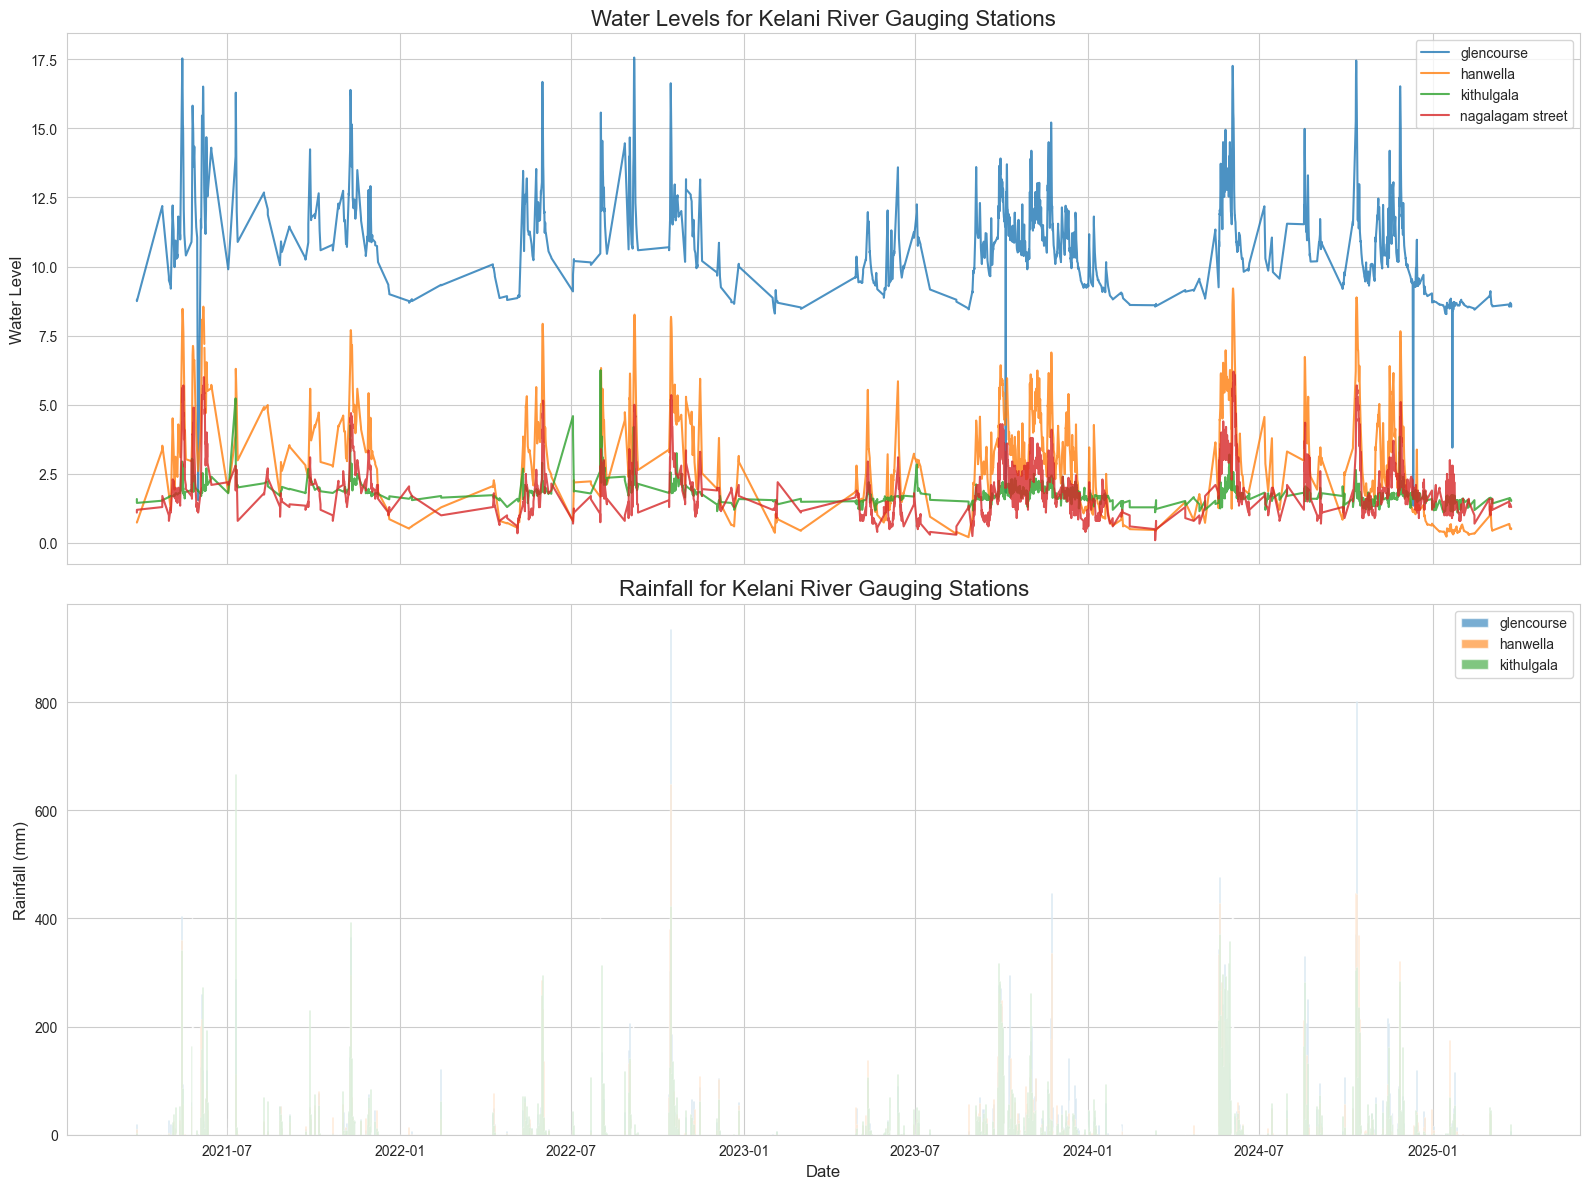

In [19]:
def get_kelani_river_data():
    """
    Get water level and rainfall data for all gauging stations on the Kelani River.
    
    Returns:
        Dictionary with station names as keys and pandas DataFrames of data as values
    """
    # Connect to database using the connection function that only returns connection
    connection = connect_to_supabase()
    cursor = connection.cursor() if connection else None
    
    if cursor is None:
        print("Failed to connect to database")
        return {}
    
    # Step 1: Find the tributary_or_river_id for Kelani River
    river_query = """
        SELECT tributary_or_river_id 
        FROM tributary_or_river 
        WHERE tributary_or_river_name ILIKE '%kelani%'
    """
    cursor.execute(river_query)
    river_result = cursor.fetchone()
    
    if not river_result:
        print("Kelani River not found in the database")
        if cursor: cursor.close()
        if connection: connection.close()
        return {}
    
    kelani_river_id = river_result[0]
    print(f"Found Kelani River with ID: {kelani_river_id}")
    
    # Step 2: Get all gauging stations on Kelani River
    stations_query = f"""
        SELECT station_id, station_name
        FROM gauging_station
        WHERE tributary_or_river_id = {kelani_river_id}
        ORDER BY station_name
    """
    cursor.execute(stations_query)
    station_results = cursor.fetchall()
    
    if not station_results:
        print("No gauging stations found for Kelani River")
        if cursor: cursor.close()
        if connection: connection.close()
        return {}
    
    print(f"Found {len(station_results)} gauging stations on Kelani River:")
    for station_id, station_name in station_results:
        print(f"  • {station_name} (ID: {station_id})")
    
    # Step 3: Get data for each station
    kelani_data = {}
    
    # Create data directories if they don't exist
    import os
    os.makedirs('./data/kelani_river/water_levels', exist_ok=True)
    os.makedirs('./data/kelani_river/rainfall', exist_ok=True)
    
    # For each station, get water level and rainfall data
    for station_id, station_name in station_results:
        station_data = {}
        station_name_simplified = station_name.lower().replace(' ', '_')
        
        print(f"\nProcessing data for {station_name}...")
        
        # Step 3a: Get water level data
        print(f"  Fetching water level data...")
        water_level_query = f"""
            SELECT recorded_at, unit, water_level 
            FROM water_level_measurement
            WHERE station_id = {station_id}
            ORDER BY recorded_at
        """
        cursor.execute(water_level_query)
        water_level_rows = cursor.fetchall()
        
        # Step 3b: Get rainfall data
        print(f"  Fetching rainfall data...")
        rainfall_query = f"""
            SELECT end_time, duration_hours, rainfall_in_mm
            FROM rainfall_measurement
            WHERE station_id = {station_id}
            ORDER BY end_time
        """
        cursor.execute(rainfall_query)
        rainfall_rows = cursor.fetchall()
        
        # Process water level data
        if water_level_rows:
            import pandas as pd
            water_df = pd.DataFrame(water_level_rows, columns=["recorded_at", "unit", "water_level"])
            water_df['recorded_at'] = pd.to_datetime(water_df['recorded_at'])
            water_df.set_index('recorded_at', inplace=True)
            
            # Save to CSV
            water_csv_path = f'./data/kelani_river/water_levels/{station_name_simplified}_water_level.csv'
            water_df.to_csv(water_csv_path)
            
            station_data['water_level'] = water_df
            print(f"  ✓ {len(water_df)} water level records saved to {water_csv_path}")
            print(f"    Date range: {water_df.index.min()} to {water_df.index.max()}")
        else:
            print(f"  ✗ No water level data found for {station_name}")
        
        # Process rainfall data
        if rainfall_rows:
            import pandas as pd
            rainfall_df = pd.DataFrame(rainfall_rows, columns=["end_time", "duration_hours", "rainfall_in_mm"])
            rainfall_df['end_time'] = pd.to_datetime(rainfall_df['end_time'])
            rainfall_df.set_index('end_time', inplace=True)
            
            # Save to CSV
            rainfall_csv_path = f'./data/kelani_river/rainfall/{station_name_simplified}_rainfall.csv'
            rainfall_df.to_csv(rainfall_csv_path)
            
            station_data['rainfall'] = rainfall_df
            print(f"  ✓ {len(rainfall_df)} rainfall records saved to {rainfall_csv_path}")
            print(f"    Date range: {rainfall_df.index.min()} to {rainfall_df.index.max()}")
            print(f"    Total rainfall: {rainfall_df['rainfall_in_mm'].sum():.2f} mm")
        else:
            print(f"  ✗ No rainfall data found for {station_name}")
        
        # Store station data in main dictionary
        if station_data:
            kelani_data[station_name] = station_data
    
    # Close database connection
    if cursor: cursor.close()
    if connection: connection.close()
    print("\nDatabase connection closed.")
    
    return kelani_data

# Run the function
kelani_data = get_kelani_river_data()

# Visualize the results if data exists
if kelani_data:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set style for better visualizations
    sns.set_style('whitegrid')
    
    # Create subplots - one for water levels, one for rainfall
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    
    # Plot water levels
    ax1.set_title('Water Levels for Kelani River Gauging Stations', fontsize=16)
    for station_name, data in kelani_data.items():
        if 'water_level' in data:
            ax1.plot(data['water_level'].index, data['water_level']['water_level'], 
                    label=station_name, alpha=0.8)
    ax1.set_ylabel('Water Level', fontsize=12)
    ax1.legend()
    ax1.grid(True)
    
    # Plot rainfall (as bar chart)
    ax2.set_title('Rainfall for Kelani River Gauging Stations', fontsize=16)
    
    # Since rainfall might have different time resolutions between stations,
    # we'll resample to daily data for clearer visualization
    for station_name, data in kelani_data.items():
        if 'rainfall' in data:
            # Resample to daily totals
            daily_rain = data['rainfall']['rainfall_in_mm'].resample('D').sum()
            ax2.bar(daily_rain.index, daily_rain.values, 
                   label=station_name, alpha=0.6)
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Rainfall (mm)', fontsize=12)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

### Get rainfall and river water level data for all the rivers and their related guaging stations

In [20]:
def get_all_rivers_data():
    """
    Get water level and rainfall data for all gauging stations on all rivers.
    
    Returns:
        Dictionary with river names as keys and nested dictionaries of station data as values
    """
    # Connect to database
    connection = connect_to_supabase()
    cursor = connection.cursor() if connection else None
    
    if cursor is None:
        print("Failed to connect to database")
        return {}
    
    # Step 1: Get all rivers from the database
    rivers_query = """
        SELECT tributary_or_river_id, tributary_or_river_name
        FROM tributary_or_river
        ORDER BY tributary_or_river_name
    """
    cursor.execute(rivers_query)
    river_results = cursor.fetchall()
    
    if not river_results:
        print("No rivers found in the database")
        if cursor: cursor.close()
        if connection: connection.close()
        return {}
    
    print(f"Found {len(river_results)} rivers in the database:")
    for river_id, river_name in river_results:
        print(f"  • {river_name} (ID: {river_id})")
    
    # Dictionary to store all data
    all_rivers_data = {}
    
    # Step 2: Process each river
    for river_id, river_name in river_results:
        print(f"\n==== Processing {river_name} ====")
        
        # Create river entry in data dictionary
        river_key = river_name.lower().replace(' ', '_')
        all_rivers_data[river_key] = {
            'name': river_name,
            'id': river_id,
            'stations': {}
        }
        
        # Step 2a: Get all stations for this river
        stations_query = f"""
            SELECT station_id, station_name
            FROM gauging_station
            WHERE tributary_or_river_id = {river_id}
            ORDER BY station_name
        """
        cursor.execute(stations_query)
        station_results = cursor.fetchall()
        
        if not station_results:
            print(f"  No gauging stations found for {river_name}")
            continue
        
        print(f"  Found {len(station_results)} gauging stations for {river_name}:")
        for station_id, station_name in station_results:
            print(f"    • {station_name} (ID: {station_id})")
        
        # Create data directories if they don't exist
        import os
        river_dir = f'./data/rivers/{river_key}'
        os.makedirs(f'{river_dir}/water_levels', exist_ok=True)
        os.makedirs(f'{river_dir}/rainfall', exist_ok=True)
        
        # Step 3: Process each station for this river
        for station_id, station_name in station_results:
            station_data = {}
            station_name_simplified = station_name.lower().replace(' ', '_')
            
            print(f"\n  Processing data for {station_name}...")
            
            try:
                # Step 3a: Get station metadata
                metadata_query = f"""
                    SELECT alert_level, minor_flood_level, major_flood_level,
                           ST_X(coordinate_wgs84::geometry) AS longitude, 
                           ST_Y(coordinate_wgs84::geometry) AS latitude,
                           measurement_unit
                    FROM gauging_station
                    WHERE station_id = {station_id}
                """
                cursor.execute(metadata_query)
                metadata_result = cursor.fetchone()
                
                if metadata_result:
                    station_data['metadata'] = {
                        'id': station_id,
                        'name': station_name,
                        'alert_level': metadata_result[0],
                        'minor_flood_level': metadata_result[1],
                        'major_flood_level': metadata_result[2],
                        'longitude': metadata_result[3],
                        'latitude': metadata_result[4],
                        'measurement_unit': metadata_result[5] if len(metadata_result) > 5 else None
                    }
                
                # Step 3b: Get water level data
                print(f"    Fetching water level data...")
                water_level_query = f"""
                    SELECT recorded_at, unit, water_level 
                    FROM water_level_measurement
                    WHERE station_id = {station_id}
                    ORDER BY recorded_at
                """
                cursor.execute(water_level_query)
                water_level_rows = cursor.fetchall()
                
                # Step 3c: Get rainfall data
                print(f"    Fetching rainfall data...")
                rainfall_query = f"""
                    SELECT end_time, duration_hours, rainfall_in_mm
                    FROM rainfall_measurement
                    WHERE station_id = {station_id}
                    ORDER BY end_time
                """
                cursor.execute(rainfall_query)
                rainfall_rows = cursor.fetchall()
                
                import pandas as pd
                
                # Process water level data
                if water_level_rows:
                    water_df = pd.DataFrame(water_level_rows, columns=["recorded_at", "unit", "water_level"])
                    water_df['recorded_at'] = pd.to_datetime(water_df['recorded_at'])
                    water_df.set_index('recorded_at', inplace=True)
                    
                    # Save to CSV
                    water_csv_path = f'{river_dir}/water_levels/{station_name_simplified}_water_level.csv'
                    water_df.to_csv(water_csv_path)
                    
                    station_data['water_level'] = water_df
                    print(f"    ✓ {len(water_df)} water level records saved to {water_csv_path}")
                    print(f"      Date range: {water_df.index.min()} to {water_df.index.max()}")
                else:
                    print(f"    ✗ No water level data found for {station_name}")
                
                # Process rainfall data
                if rainfall_rows:
                    rainfall_df = pd.DataFrame(rainfall_rows, columns=["end_time", "duration_hours", "rainfall_in_mm"])
                    rainfall_df['end_time'] = pd.to_datetime(rainfall_df['end_time'])
                    rainfall_df.set_index('end_time', inplace=True)
                    
                    # Save to CSV
                    rainfall_csv_path = f'{river_dir}/rainfall/{station_name_simplified}_rainfall.csv'
                    rainfall_df.to_csv(rainfall_csv_path)
                    
                    station_data['rainfall'] = rainfall_df
                    print(f"    ✓ {len(rainfall_df)} rainfall records saved to {rainfall_csv_path}")
                    print(f"      Date range: {rainfall_df.index.min()} to {rainfall_df.index.max()}")
                    print(f"      Total rainfall: {rainfall_df['rainfall_in_mm'].sum():.2f} mm")
                else:
                    print(f"    ✗ No rainfall data found for {station_name}")
                
                # Store station data in river dictionary
                if len(station_data) > 1:  # More than just metadata
                    all_rivers_data[river_key]['stations'][station_name_simplified] = station_data
            
            except Exception as e:
                print(f"    ✗ Error processing station {station_name}: {str(e)}")
                continue
    
    # Close database connection
    if cursor: cursor.close()
    if connection: connection.close()
    print("\nDatabase connection closed.")
    
    # Create a summary report
    print("\n===== DATA COLLECTION SUMMARY =====")
    rivers_with_data = 0
    stations_with_data = 0
    total_water_records = 0
    total_rainfall_records = 0
    
    for river_key, river_data in all_rivers_data.items():
        if river_data['stations']:
            rivers_with_data += 1
            station_count = len(river_data['stations'])
            stations_with_data += station_count
            
            water_records = 0
            rainfall_records = 0
            
            for station_key, station_data in river_data['stations'].items():
                if 'water_level' in station_data:
                    water_records += len(station_data['water_level'])
                if 'rainfall' in station_data:
                    rainfall_records += len(station_data['rainfall'])
            
            total_water_records += water_records
            total_rainfall_records += rainfall_records
            
            print(f"\n{river_data['name']}:")
            print(f"  - {station_count} stations with data")
            print(f"  - {water_records} water level records")
            print(f"  - {rainfall_records} rainfall records")
    
    print(f"\nTotal: {rivers_with_data} rivers, {stations_with_data} stations")
    print(f"       {total_water_records} water level records")
    print(f"       {total_rainfall_records} rainfall records")
    
    return all_rivers_data

# Run the function
all_rivers_data = get_all_rivers_data()

Found 26 rivers in the database:
  • attanagalu oya (ID: 26)
  • badulu oya (ID: 19)
  • deduru oya (ID: 24)
  • gin ganga (ID: 8)
  • gurugoda oya (ID: 2)
  • heda oya (ID: 16)
  • kalu ganga (ID: 5)
  • kehelgamu oya (ID: 4)
  • kelani ganga (ID: 1)
  • kirindi oya (ID: 12)
  • kuda ganga (ID: 7)
  • kuda oya (ID: 13)
  • kumbukkan oya (ID: 15)
  • maduru oya (ID: 17)
  • maguru ganga (ID: 6)
  • maha oya (ID: 25)
  • mahaweli ganga (ID: 18)
  • malwathu oya (ID: 22)
  • mee oya (ID: 23)
  • menik ganga (ID: 14)
  • mukunu oya (ID: 21)
  • nilwala ganga (ID: 9)
  • seethawaka ganga (ID: 3)
  • urubokka ganga (ID: 10)
  • walawe ganga (ID: 11)
  • yan oya (ID: 20)

==== Processing attanagalu oya ====
  Found 1 gauging stations for attanagalu oya:
    • dunamale (ID: 39)

  Processing data for dunamale...
    Fetching water level data...
    Fetching rainfall data...
    ✓ 2407 water level records saved to ./data/rivers/attanagalu_oya/water_levels/dunamale_water_level.csv
      Date ra